# The Aggravation Problem

This would be an overview of our journey into aggregating individual predictions to a group level. The major points addressed would be:

 - Bias Introduced by model
 - Bias introduced by target vectors (dropout)
 - Error contribution of group trend
 - Accounting of Error

For this I envision a plot heavy blog posting showing how various aspects above contribute error, how we mitigate or account for this error and general discussion. The would be no optimal ‘solution’ presented but maybe some code on plots.

In [ ]:
### Comments From Charles
 - Boxplots Not Linear ScatterPlots
 - Consistency between residuals / predictions / true values
 - Better problem building
 - Better Mathematical organization / definition / follow through
 - Better connection of problem to healthcare in conclusion
 - Find outside reference for advantages in predicting individual health (Lumiata, research paper etc.)

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def f(x):
    return x**2

def get_sim_data(f, var, sample_size=200):
    x = np.random.uniform(size = sample_size, low = 0, high = 1.5)
    y = np.random.normal(size = sample_size, loc=f(x), scale = var)
    return pd.DataFrame(dict(bias=1,x=x,y=y))

def transform(dat, degree):
    
    y = np.empty(shape = dat.shape[0])
    if 'y' in dat.columns:
        y = dat['y']
    
    if degree == 0:
        X = np.ones((y.shape[0],1))
        return X,y
    
    x_cols = ['bias', 'x']
    if degree >= 2:
        for i in range(2,degree+1):
            col = 'x_{:,}'.format(i)
            dat[col]=dat['x']**i
            x_cols.append(col)
    
    X = dat[x_cols]
    return X,y
    

def fit(dat, degree):
    
    X,y = transform(dat, degree)
    
    LR = LinearRegression().fit(X,y)
    
    return LR


def predict(model, dat, degree):
    
    X,_ = transform(dat, degree)
    
    return model.predict(X)


def plot_fit(data, fit):

    plt.scatter(
        data['x'],
        data['y'],
        alpha = .25,
        s = 5,
        color = 'grey'
    )

    sort = np.argsort(data['x'])
    plt.plot(
        data['x'][sort],
        fit[sort]
    )


def plot_a(row,col,index):
    
    train = get_sim_data(f, var)
    X = pd.DataFrame({
        'x' : np.arange(0,1.5,.01)
    })
    X['bias'] = 1
    legend = []
    
    plt.subplot(row,col,index)
    plt.scatter(
        train['x'],
        train['y'],
        alpha = .5,
        s = 10,
        color = 'grey'
    )

    for degree in [1,2,10]:
        model = fit(train, degree)
        p = predict(model, X, degree)

        plt.plot(
            X['x'],
            p
        )

        plt.subplots_adjust(top=0.8)

        if index == 1:
            plt.ylabel('Response ( Y )\n')
        plt.xlabel('\n Feature ( X )')
        legend.append('k={:,}'.format(degree))
        plt.xlim(0,1.5)
        plt.ylim(-.5,2.5)

    if col == 1:
        plt.legend(legend,loc='upper left')
        
        
def plot_b(
    N,
    f,
    x, 
    var,
    col,
    index,
    sample_size,
    title=False
):

    X = pd.DataFrame({
        'x' : [x],
        'bias' : [1]
    })

    preds = defaultdict(list)
    legend = []

    for degree in [1,2,10]:
        for _ in range(100):
            train = get_sim_data(f, var, sample_size)
            model = fit(train, degree)
            p = predict(model, X, degree)
            preds[degree].append(N * f(x) - N * p[0])

    for _ in range(100):
        e = np.random.normal(
            0,
            scale=np.sqrt(var),
            size=N)
        preds['e'].append(e.sum())

    preds = pd.DataFrame(preds)
    preds = pd.melt(preds, var_name='k', value_name='Difference to f(x)')
    
    plt.subplot(1,col,index)
    sns.boxplot(
        data = preds,
        x = 'k',
        y = 'Difference to f(x)'
    )
    
    if index == 1:
        plt.legend([
            r'$f_{1}$',
            r'$f_{2}$',
            r'$f_{10}$'
        ])
        
    else:
        plt.ylabel('')
        plt.ylim(-.5*N,.5*N)
        
    
def exhibit_a():
    plt.style.use('seaborn')
    plt.figure(figsize=(15,7.5))
    plt.title(
        'Various Model Fits to Simuluted Data',
        fontsize = 15, 
        y = 1.1
    )

    plot_a(1,1,1)
    plt.show()
    plt.figure(figsize=(15,3))
    plot_a(1,3,1)
    plt.title('Simulated Data 1\n')
    plot_a(1,3,2)
    plt.title('Simulated Data 2\n')
    plot_a(1,3,3)
    _ = plt.title('Simulated Data 3\n')
    plt.show()

    # TODO:
    # 1. Add bigger/bold titles
    # 2. Add bold labels
    # 3. Pretend like you can see this code
    
def exhibit_b():
    
    plt.figure(figsize=(15,7.5))
    plot_b(N=1,f=f,x=.8,var=1,col=1,index=1,sample_size=100)
    plt.title('Distribution of Predictions For Various Model Fits \n')
    plt.ylabel('Difference to best possible estimate: f(x) \n')
    plt.xlabel('')

    # TO DO: 
    # 1. Fix Sizing on title / labels
    # 2. Better Colors
    # 3. Fix size between plots
    # 4. Exclude Irreducible error?
    
def exhibit_c():
    index = 1
    plt.figure(figsize=(15,7.5))
    for N in [1,10,100,1000]:
        plot_b(N,f=f,x=.8,var=var,col=4,index=index,sample_size=100)
        title='N = {:,}'.format(N)
        plt.title(title)
        index += 1
    plt.suptitle(r'Distribution of Difference to $f(x)$ For Various Model Fits (Agg. N Predictions)')
    plt.show()

### Introduction

The purpose of this post is a revisit the bias-variance tradeoff with additional comments on how it pertains to aggregated individual predictions. 

Plans in healthcare have been historically priced in bulk, which is done to eleviate risk to individuals by putting money into pools (necessary? better intro? CLT thoughts? read something about health insurance). When predicting for this cost, it is typical to use aggregated features such as historical account cost, account region and some measure of prior high cost claimants. 

However, the account level view is an extreme dilution of a very complex cost relationship between patient health, hospitals and providers. For example, there are thousands of possible ICD and CPT codes (Explanation of these?) that explain the multitudes of reasons a person would need treatment and how treatment is applied. This is complicated with the varying ways that these cost are uniquely assigned by hospitals and doctors. Considering these codes both in context of time and their potential interactions provides a very rich feature space (high dimensionality? Better wording here). Targetting this information, Lumiata has built a robust patient tagging process capable of translating this wealth of claims data into ingestible patient timelines.

However, it would be a mistake to naively aggregate individual level predictions to bridge the gap to account level predictions. One problem with this is that it leaves us susceptible to exaggerated error rates due to problems inherrent to modelling, something we can better understand with a review of the bias-variance tradeoff. 

### Break-Down of Expected Prediction Error

For a more in depth review of the bias-variance tradeoff, I would suggest David Dalpiaz's great online resource, <a href="https://daviddalpiaz.github.io/r4sl/biasvariance-tradeoff.html"> R for Statistical Learning </a>. The examples I am providing here are directly from this resource, albeit slightly adapted to demonstrate our puposes. 

As David Dalpiaz shows, if we condition on a given training dataset, $\mathcal{D}$ and on $X$, model error can be split into **reducible error** and **irreducible error**. 

$$\text{EPE}(Y,\hat f(x)) = \underbrace{\mathbb{E}_{\mathcal{D}}[(f(x) - \hat f(x))^2]}_\textrm{reducible error} + \underbrace{\mathbb{V}_{Y|X}[Y|X=x]}_\textrm{irreducible error}$$

From this we can derive **bias** and **variance**. 

$$\text{EPE}(Y,\hat f(x)) = \underbrace{(f(x) - \mathbb{E}[\hat f(x)])^2}_{bias^2} + \underbrace{\mathbb{E}[(\hat f(x) - \mathbb{E}[\hat f(x)])^2]}_{variance} + \underbrace{\mathbb{V}_{Y|X}[Y|X=x]}_\textrm{irreducible error}$$



Understanding the error composition provides the framework for how we can understand the impact of modelling decisions on prediction error.

### Bias-Variance Tradeoff

At a very high level, it may be useful to interpret bias, as the rigidity or strength of assumptions of a given model. A highly biased model may make assumptions on the form of association with features (Linear Regression), covariance with local features (Large N-Neighbors) and/or restricting the feature set size. Bias can also be inadvertently introduced by sampling a non-representative population for $X$ or failing to include key features in a model. Conversely, relaxing the above restrictions, increases model flexibility allowing for a more nuanced response surface. However this flexibility will tend to fit relationships that are inherent to a given training set rather than the population. 

In our particular example, again adapted from David Dalpiaz’s simulation we demonstrate the concepts of introduced bias and variance by tuning the number of polynomial features. 

In each plot below, we randomly sample from &nbsp;$(X,Y)$, where &nbsp;$X \in \mathbb{U}[0,1]$, &nbsp;$\mathbb{V}[Y|X=x] = .3$ and &nbsp;$\mathbb{E}[Y|X=x] = x^2$. The models we have chosen to fit the randomly sampled data are defined as &nbsp;$\hat f_k = \sum_{i=0}^k W_kx$ for the various &nbsp;$k \in (1,2,10)$

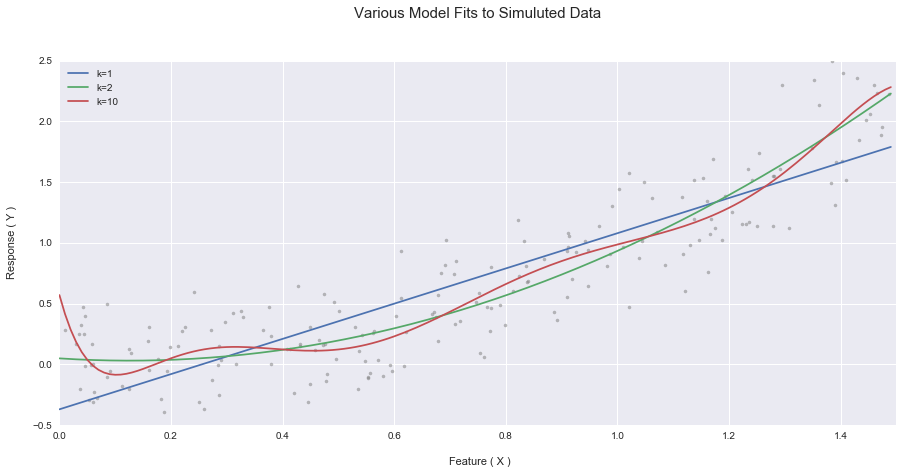

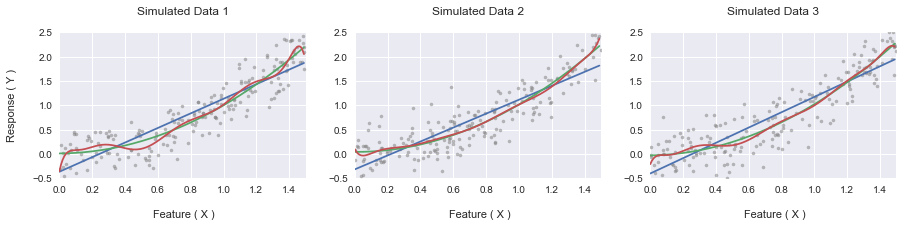

In [75]:
var = .3
exhibit_a()

Falling back on our analogy, we see that our 'rigid' or biased model &nbsp;$\hat f_1$ seems quite consistent as we change the training data, even if it is consistently missing the true form of &nbsp;$f$, which we have defined as &nbsp;$x^2$. At the other end of the spectrum we see that  &nbsp;$\hat f_{10}$ while following the trend of the data, seems to vary a large deal from simulation to simulation. 

In order to get a better idea for what is happening each time we repeatedly sample, train and apply a model. We can only observe values at which $x=.8$, in addition to a prediction we use our assume target distribution to randomly generating true values. Repeating this 100 times allows us to create a residual distribution for each &nbsp;$f_k$.

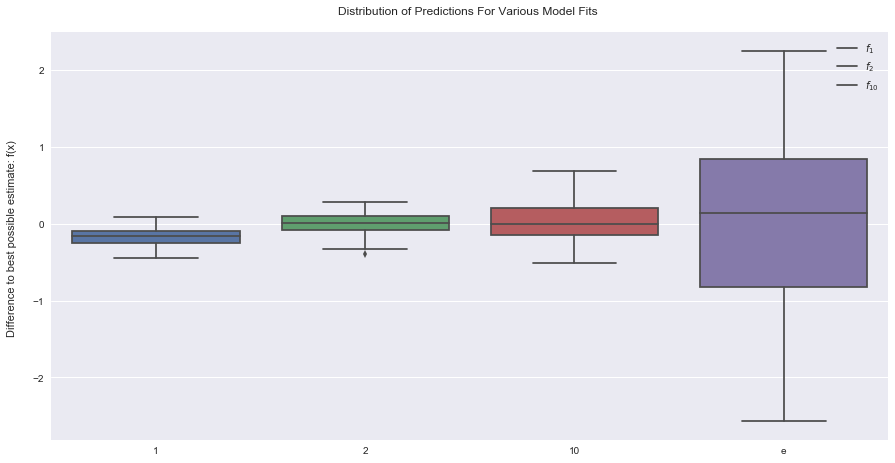

In [97]:
exhibit_b()

### The problem with Aggregation

As we initially stated in our introduction it would be a mistake to naively aggregate predictions as error compound in different ways. We are now in a position where we can examine this. Revisiting our breakdown of **reducible error** and **irreducible error** we first reaffirm that we are conditioning on $X$ and on $\mathcal{D}$. Making these assumptions, we can see how naive aggregation effects the expected composition of error.

$$\text{EPE}(\sum^N Y,N \hat f(x)) = \underbrace{\mathbb{E}_{\mathcal{D}}[(Nf(x) - N\hat f(x))^2]}_\textrm{reducible error} + \underbrace{\sum^N \mathbb{V}_{Y|X}[Y|X=x]}_\textrm{irreducible error}$$ 

$$N^2 (\underbrace{\mathbb{E}_{\mathcal{D}}[(f(x) - \hat f(x))^2]}_\textrm{reducible error}) + N (\underbrace{ \mathbb{V}_{Y|X}[Y|X=x]}_\textrm{irreducible error})$$

To illustrate this point, we examine the distribution of $Nf_k(x) - Nf(x)$ and $\sum y - f(x)$ demonstrates the distribution of difference  with varying degrees of aggregation. We can see that **reducible error** compounds by a factor of $N$, whereas **irreducible error** compounds by a factor of $\sqrt(N)$. 

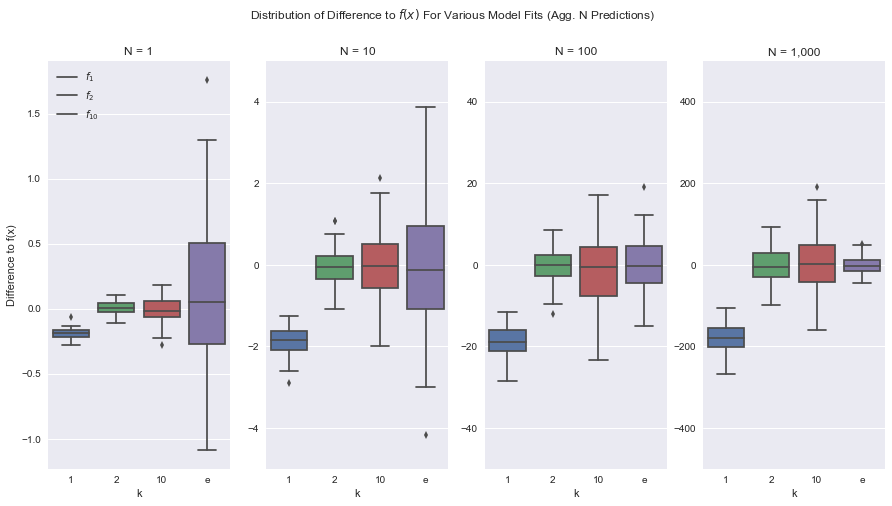

In [98]:
exhibit_c()

Since $\hat f(x)$ is fixed at the point of application, it is easy to intuit that any deviation from $f(x)$ is compounded linearly with each aggregation. However, we see that as proportion of total error, **irreducible error** actually decreases as we increase the size of N. 



### Conclusion

In [ ]:
TO DO:
1. Label with N
2. Synchronize axis ticks
3. Maybe certain N aggregations
4. Maybe different plot organization

# PRIOR EXMANATION OF EXHIBIT A
To start, let us examine a set of data such that $(X,Y) \in \mathbb{R}^p x \mathbb{R}$. For this data, we would like to usee the current state of $X$ to make a guess for $Y$. To measure for how well we guess, for which we choose the squared loss function $(Y - f(X))^2$. Which, in addition to being the traditional loss function has a number of practical uses included being symetric, convex and easily derived. It can be show that, for a given $x$, the value which minimizes our loss is the mean of the conditional population of $Y$. Thus the best possible predictions that we can make on average is defined as:

$$f(x) \triangleq \mathbb{E}(Y|X=x)$$

However, inplicit in this statement is the underastanding that $X$ does not describe all of the variance of $Y$. Thus, introducing Expected Prediction Error (EPE), we formally recognize this as irreducible error. 

$$EPE(Y,f(x)) = \mathbb{E}_{Y|X}[(Y-f(X))^2|X=x] = \underbrace{\mathbb{V}_{Y|X}[Y|X=x]}_\textrm{irreducible error}$$

Since we also don't know true form of $f(X)$, (sigh) we will have to approximate it using tools from the the data science toolkit, algorithms and training data. We call this estimated function $\hat f(X)$. 

This brings us to the crux to understanding the bias-variance tradeoff. We can observe that the model that we have approximated is itself a random variable that is dependent on $X$ and the algorithm we have chosen. In other words, should we generate a new set of training data $\mathcal{D}$ and/or change the model, we would would likely get a different $\hat f(x)$ and therefore a different set of predictions. This function we hope to get as possible the optimal $f(X)$. Errors due to our approximations can be characterized as:

$$\text{EPE}(Y,\hat f(x)) = \underbrace{\mathbb{E}_{\mathcal{D}}[(f(x) - \hat f(x))^2]}_\textrm{reducible error} + \underbrace{\mathbb{V}_{Y|X}[Y|X=x]}_\textrm{irreducible error}$$

At we can bring out several other definitions, the first of which is bias, which is defined as:

$$\text{bias}(\hat \theta) \triangleq \mathbb{E}[\hat \theta] - \theta$$

We can also review the definition of variance.

$$\mathbb V(\hat \theta) \triangleq \mathbb{E}[X^2] - \mathbb{E}[X]^2 = \mathbb{E}[\hat \theta - \mathbb{E}[\hat \theta])^2]$$

Using these definitions we can rewrite the above equation as follows.

$$\text{EPE}(Y,\hat f(x)) = \underbrace{(f(x) - \mathbb{E}[\hat f(x)])^2}_{bias^2} + \underbrace{\mathbb{E}[(\hat f(x) - \mathbb{E}[\hat f(x)])^2]}_{variance} + \underbrace{\mathbb{V}_{Y|X}[Y|X=x]}_\textrm{irreducible error}$$


# PRIOR SUMMARY OF EXHIBIT B
we condition on $X=.8$, implying that $f(.8) = .64$. Additionally, we generate 100 random samples of (X,Y) and for each generate fit a model and generate a prediction $\hat f_k(.8)$. Doing so allows us to demonstrate the distribution of $\hat f_k(x)$ for each $k \in (1,2,10)$. Since the ultimate goal is to correctly approximate $f(x)$, the actual values plotted is $f(x) - \hat f_k(x)$. To round out our examination of error, we also plot the distribution of **irreducible error**, $y-f(x)$. 

### How this relates to Healthcare

TO DO:
1. Talk about how this is construed example to demonstrate a purpose (generally unlikely to get fixed X)
2. Talk about how account tend to homogenous
3. Fill in how bias is introduced in healthcare
    - Overfit to test data
    - Size of data to feature space is not sufficient
    - Outliers skew features
4. Simple explantion on proper cross validation techiques and bias correction models